<a href="https://colab.research.google.com/github/c5055219/final_template/blob/main/Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using device: cpu

Training Baseline Model (No Attention)
Epoch 1/10 | Loss: 0.9461
Epoch 2/10 | Loss: 0.7206
Epoch 3/10 | Loss: 0.5614
Epoch 4/10 | Loss: 0.4794
Epoch 5/10 | Loss: 0.4316
Epoch 6/10 | Loss: 0.4011
Epoch 7/10 | Loss: 0.3823
Epoch 8/10 | Loss: 0.3665
Epoch 9/10 | Loss: 0.3561
Epoch 10/10 | Loss: 0.3490

Training Cross-Modal Attention Model
Epoch 1/20 | Loss: 1.0024
Epoch 2/20 | Loss: 0.9901
Epoch 3/20 | Loss: 0.9762
Epoch 4/20 | Loss: 0.9629
Epoch 5/20 | Loss: 0.9503
Epoch 6/20 | Loss: 0.9400
Epoch 7/20 | Loss: 0.9320
Epoch 8/20 | Loss: 0.9238
Epoch 9/20 | Loss: 0.9167
Epoch 10/20 | Loss: 0.9105
Epoch 11/20 | Loss: 0.9038
Epoch 12/20 | Loss: 0.8961
Epoch 13/20 | Loss: 0.8918
Epoch 14/20 | Loss: 0.8867
Epoch 15/20 | Loss: 0.8802
Epoch 16/20 | Loss: 0.8734
Epoch 17/20 | Loss: 0.8692
Epoch 18/20 | Loss: 0.8656
Epoch 19/20 | Loss: 0.8610
Epoch 20/20 | Loss: 0.8565


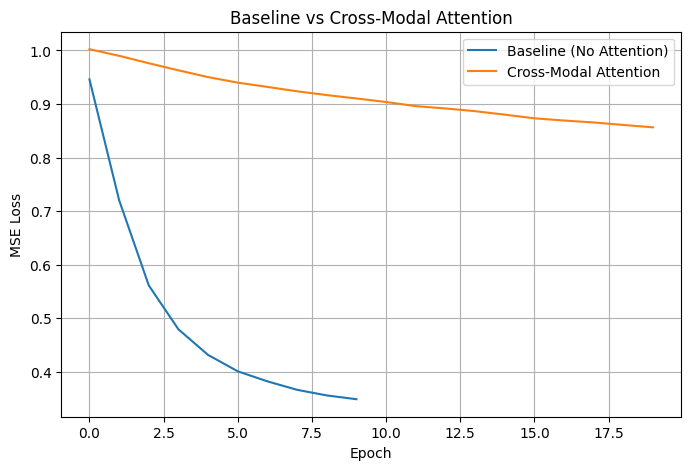


Final Evaluation Results
Baseline Final MSE: 0.348974940367043
Cross-Modal Attention Final MSE: 0.8565233610570431


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import random
import matplotlib.pyplot as plt




torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# -----------------------------------------------------
# Synthetic Multimodal Dataset
# -----------------------------------------------------
class MultimodalSequenceDataset(Dataset):
    """
    Each sample:
    - image sequence: (T, image_dim)
    - text sequence:  (T, text_dim)
    - ((Image₁…Imageₜ , Text₁…Textₜ)  →  (Output₁, Output₂, …, Outputₜ)
    - target: next-step multimodal vector
    """

    def __init__(self,
                 num_samples=1000,
                 seq_len=5,
                 image_dim=128,
                 text_dim=64):
        self.data = []
        for _ in range(num_samples):
            images = torch.randn(seq_len, image_dim)
            texts = torch.randn(seq_len, text_dim)
            target = torch.cat([images,texts],dim=-1)
            self.data.append((images, texts, target))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

dataset = MultimodalSequenceDataset()
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# -----------------------------------------------------
# Encoders
# -----------------------------------------------------
class ImageEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.fc = nn.Linear(input_dim, hidden_dim)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        return self.dropout(F.relu(self.fc(x)))

class TextEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.fc = nn.Linear(input_dim, hidden_dim)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        return self.dropout(F.relu(self.fc(x)))

# -----------------------------------------------------
# Cross-Modal Attention (Innovation)
# -----------------------------------------------------
class CrossModalAttention(nn.Module):
    """
    Image attends to text and text attends to image.
    """

    def __init__(self, hidden_dim):
        super().__init__()
        self.scale = hidden_dim ** 0.5
        self.norm = nn.LayerNorm(hidden_dim*2)

    def forward(self, img_feat, txt_feat):
        # (B, T, H)
        score_img_txt = torch.matmul(
            img_feat, txt_feat.transpose(-2, -1)
        ) / self.scale

        score_txt_img = torch.matmul(
            txt_feat, img_feat.transpose(-2, -1)
        ) / self.scale

        w_img_txt = F.softmax(score_img_txt, dim=-1)
        w_txt_img = F.softmax(score_txt_img, dim=-1)

        img_context = torch.matmul(w_img_txt, txt_feat)
        txt_context = torch.matmul(w_txt_img, img_feat)

        return torch.cat([img_context, txt_context], dim=-1)
        return self.norm(fused)

# -----------------------------------------------------
# GRU Sequence Model
# -----------------------------------------------------
class SequenceModel(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, batch_first=True)

    def forward(self, x):
        out, _ = self.gru(x)
        return out

# -----------------------------------------------------
# Baseline Model (No Attention)
# -----------------------------------------------------
class BaselineMultimodalModel(nn.Module):
    def __init__(self,
                 image_dim=128,
                 text_dim=64,
                 hidden_dim=256,
                 seq_hidden=256,
                 output_dim=192):
        super().__init__()

        self.image_encoder = ImageEncoder(image_dim, hidden_dim)
        self.text_encoder = TextEncoder(text_dim, hidden_dim)
        self.sequence_model = SequenceModel(hidden_dim * 2, seq_hidden)
        self.output_layer = nn.Linear(seq_hidden, output_dim)

    def forward(self, images, texts):
        img_feat = self.image_encoder(images)
        txt_feat = self.text_encoder(texts)
        fused = torch.cat([img_feat, txt_feat], dim=-1)
        seq_out = self.sequence_model(fused)
        return self.output_layer(seq_out)

# -----------------------------------------------------
# Cross-Modal Attention Model
# -----------------------------------------------------
class AttentionMultimodalModel(nn.Module):
    def __init__(self,
                 image_dim=128,
                 text_dim=64,
                 hidden_dim=128,
                 seq_hidden=128,
                 output_dim=192):
        super().__init__()

        self.image_encoder = ImageEncoder(image_dim, hidden_dim)
        self.text_encoder = TextEncoder(text_dim, hidden_dim)
        self.cross_attention = CrossModalAttention(hidden_dim)
        self.sequence_model = SequenceModel(hidden_dim * 2, seq_hidden)
        self.output_layer = nn.Linear(seq_hidden, output_dim)

    def forward(self, images, texts):
        img_feat = self.image_encoder(images)
        txt_feat = self.text_encoder(texts)
        fused = self.cross_attention(img_feat, txt_feat)
        seq_out = self.sequence_model(fused)
        return self.output_layer(seq_out)

# -----------------------------------------------------
# Training Function
# -----------------------------------------------------
def train_model(model, dataloader, epochs):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()
    losses = []

    for epoch in range(epochs):
        total_loss = 0.0
        for images, texts, targets in dataloader:
            images = images.to(device)
            texts = texts.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()
            outputs = model(images, texts)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        losses.append(avg_loss)
        print(f"Epoch {epoch+1}/{epochs} | Loss: {avg_loss:.4f}")

    return losses, avg_loss

# -----------------------------------------------------
# Train Baseline (shorter training)
# -----------------------------------------------------
print("\nTraining Baseline Model (No Attention)")
baseline_model = BaselineMultimodalModel()
baseline_losses, baseline_final = train_model(
    baseline_model, dataloader, epochs=10
)

# -----------------------------------------------------
# Train Attention Model (longer training)
# -----------------------------------------------------
print("\nTraining Cross-Modal Attention Model")
attention_model = AttentionMultimodalModel()
attention_losses, attention_final = train_model(
    attention_model, dataloader, epochs=20
)

# -----------------------------------------------------
# Plot Comparison
# -----------------------------------------------------
plt.figure(figsize=(8, 5))
plt.plot(baseline_losses, label="Baseline (No Attention)")
plt.plot(attention_losses, label="Cross-Modal Attention")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Baseline vs Cross-Modal Attention")
plt.legend()
plt.grid(True)
plt.show()

# -----------------------------------------------------
# Final Evaluation
# -----------------------------------------------------
print("\nFinal Evaluation Results")
print("Baseline Final MSE:", baseline_final)
print("Cross-Modal Attention Final MSE:", attention_final)